# Test coordinates

In [ ]:
import mne
import nibabel as nb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
# Load position of the electrodes
elec_pos = '/home/mcesped/scratch/Results/seegprep/hipp_run/bids/sub-068/ses-005/ieeg/sub-068_ses-005_task-full_rec-regionID_run-01_regions_native_space.tsv'
elec_df = pd.read_csv(elec_pos, sep='\t')
elec_df.head()

In [ ]:
mri_ras_mm = elec_df[
        ['x_init', "y_init", "z_init"]
    ].values

In [ ]:
mri_ras_mm

In [ ]:
elec_df[elec_df['label']=='RHc1-2']

In [ ]:
pos_test = [22.81, 18.593, -8.192]

In [ ]:
def readRegMatrix(trsfPath):
	with open(trsfPath) as (f):
		return np.loadtxt(f.readlines())

In [ ]:
tf_7T_to_clinical = '/home/mcesped/scratch/Results/seegprep/hipp_run/work/sub-068/anat/sub-068_tf.txt'
tf_obj = readRegMatrix(tf_7T_to_clinical)

In [ ]:
# Get pos in 7T space
pos_7T = mne.transforms.apply_trans(tf_obj, pos_test)

In [ ]:
# Load the 7T to check that it's okay
img_7T = '/home/mcesped/scratch/Results/hippunfold/batch-hippunfold/hippunfold/sub-P060/anat/sub-P060_desc-preproc_T1w.nii.gz'
t1_obj = nb.load(img_7T)

In [ ]:
# Visualize in 7T space
inv_affine = np.linalg.inv(t1_obj.affine)
vox = np.round(mne.transforms.apply_trans(inv_affine, pos_7T)).astype(int)
vox

In [ ]:
def imshow_mri(data, img, vox, suptitle, cmap='gray', vmin=None, vmax=None):
    """Show an MRI slice with a voxel annotated."""
    i, j, k = vox
    fig, ax = plt.subplots()
    codes = nb.orientations.aff2axcodes(img.affine)
    # Figure out the title based on the code of this axis
    ori_slice = dict(P='Coronal', A='Coronal',
                     I='Axial', S='Axial',
                     L='Sagittal', R='Saggital')
    ori_names = dict(P='posterior', A='anterior',
                     I='inferior', S='superior',
                     L='left', R='right')
    title = ori_slice[codes[0]]
    scale = np.max(data.shape[2]/data.shape[1])
    ax.imshow(data[i], cmap=cmap, origin='lower', aspect=scale*0.8, vmin=vmin, vmax=vmax)
    # reorient view so that RAS is always rightward and upward
    x_order = -1 if codes[2] in 'LIP' else 1
    y_order = -1 if codes[1] in 'LIP' else 1
    ax.set(xlim=[0, data.shape[2] - 1][::x_order],
           ylim=[0, data.shape[1] - 1][::y_order],
           xlabel=f'k ({ori_names[codes[2]]}+)',
           ylabel=f'j ({ori_names[codes[1]]}+)',
           title=f'{title} view: i={i} ({ori_names[codes[0]]}+)')
    fig.suptitle(suptitle)
    fig.subplots_adjust(0.1, 0.1, 0.95, 0.85)
    return fig

In [ ]:
data = np.asarray(t1_obj.dataobj)
dataplot = np.swapaxes(data, 1, 2)
fig = imshow_mri(dataplot, t1_obj, vox, 'MRI slice')
fig.axes[0].scatter(vox[1],vox[2])

In [ ]:
# Now load the 2 nifti files with the coordinates
import os
coord_dir = '/home/mcesped/scratch/Results/hippunfold/batch-hippunfold/hippunfold/sub-P060/coords/'
ap_img = nb.load(os.path.join(coord_dir, 'sub-P060_dir-AP_hemi-R_space-cropT1w_label-hipp_desc-laplace_coords.nii.gz'))
pd_img =  nb.load(os.path.join(coord_dir, 'sub-P060_dir-PD_hemi-R_space-cropT1w_label-hipp_desc-laplace_coords.nii.gz'))

In [ ]:
# Find the AP-PD value based on these 2 images
#AP
inv_affine = np.linalg.inv(ap_img.affine)
vox = np.round(mne.transforms.apply_trans(inv_affine, pos_7T)).astype(int)
AP_coord = ap_img.get_fdata()[tuple(vox)]
vox, AP_coord

In [ ]:
#PD
# Not necessary to calculate vox again
PD_coord = pd_img.get_fdata()[tuple(vox)]
vox, PD_coord

In [ ]:
coord_2D = (AP_coord, PD_coord)
coord_2D

In [ ]:
# Now load the shape.gii files for the AP, PD mapping to the midthickness
# To find the closest vertex, do a zip list of the values in the 2 shape.gii images
# and find the closest value to the previous AP,PD value found for the electrode.
gifti_dir = '/home/mcesped/scratch/Results/'
ap_gifti = nb.load(os.path.join(gifti_dir, 'sub-P060_AP_midthickness.shape.gii'))
pd_gifti =  nb.load(os.path.join(gifti_dir, 'sub-P060_PD_midthickness.shape.gii'))

In [ ]:
ap_gifti.agg_data()

In [ ]:
coords_AP_PD = np.hstack([ap_gifti.agg_data()[:,np.newaxis], ap_gifti.agg_data()[:,np.newaxis]])

In [ ]:
from scipy import spatial

In [ ]:
coords_AP_PD[spatial.KDTree(coords_AP_PD).query(coord_2D)[1]]

In [ ]:
def electrode_mask(coord, coord0=(0,0), r=1):
    if (coord[0]-coord0[0])**2 + (coord[1]-coord0[1])**2 <= r**2:
        return 1
    else:
        return 0

In [ ]:
from functools import partial
result = list(map(partial(electrode_mask, coord0 = coord_2D, r=0.1), coords_AP_PD))

In [ ]:
mask_2d = np.array(result)

In [ ]:
mask_2d

In [ ]:
meta=nb.gifti.gifti.GiftiMetaData({'AnatomicalStructurePrimary': ap_gifti.meta['AnatomicalStructurePrimary']})
datarray = nb.gifti.gifti.GiftiDataArray(mask_2d, datatype=ap_gifti.darrays[0].datatype)
mask_gifti = nb.gifti.gifti.GiftiImage(header=ap_gifti.header, file_map = ap_gifti.file_map, meta=meta, labeltable=ap_gifti.labeltable, darrays=[datarray])

In [ ]:
mask_gifti.to_filename('test_mask.shape.gii')

# Tests with data

## Get the data

In [1]:
from bids import BIDSLayout
import pandas as pd
import numpy as np
import scipy
import json
import pyedflib
import re
import nibabel as nb
import os
import xarray as xr

In [2]:
# Load dataset
data_path = '/scratch/mcesped/Results/seegprep/hipp_run/bids/'
layout = BIDSLayout(data_path, validate=False)
layout_edf = BIDSLayout('/scratch/mcesped/Results/seegprep/hipp_run/work/', validate=False)

In [3]:
tsv_files = layout.get(extension='tsv', suffix='space')
tsv_files
# ieeg_files = layout_edf.get(extension='edf', suffix='ieeg', reconstruction='PLIreject')

In [4]:
sub_sess_info = dict()
for tsv_file in tsv_files:
    # Get tsv file
    subj = tsv_file.get_entities()['subject']
    session = tsv_file.get_entities()['session']
    run = tsv_file.get_entities()['run']
    edf_files = layout_edf.get(extension='edf', suffix='ieeg', reconstruction='PLIreject', subject=subj, session=session, run=run, return_type='filename')
    json_file = layout.get(extension='json', subject=subj, session=session, run=run, return_type='filename')
    if len(json_file)>1:
        print('error')
    # Append to dict
    sub_sess_info[f'sub-{subj}_ses-{session}_run-{run}'] = {
        'channels_tsv': tsv_file.path,
        'edf_files' : edf_files,
        'subject': subj,
        'json': json_file[0]
    }

In [5]:
sub_sess_info[list(sub_sess_info.keys())[95]]

## Analysis

In [1]:
import pandas as pd
import numpy as np
import scipy
import os
import xarray as xr

In [2]:
label_test = 'all_epi'

### Bandpower analysis

In [3]:
# Load the dataarray
ds = xr.open_dataset(f"./Data/{label_test}/ds_{label_test}_freq_reduced.nc")
# Update text inputs
# for coord in ['subj_chn', 'group', 'chn', 'subj']:
#     ds.coords[coord] = ds.coords[coord].astype('<U32')
# for coord in ['PD', 'AP']:
#     ds.coords[coord] = ds.coords[coord].astype('float64')
ds

<xarray.Dataset>
Dimensions:    (frequency: 159, n: 34, f_bands: 5)
Coordinates:
  * frequency  (frequency) float64 0.5 1.0 1.5 2.0 2.5 ... 78.0 78.5 79.0 79.5
    subj_chn   (n) object ...
    group      (n) object ...
    chn        (n) object ...
    subj       (n) object ...
    PD         (n) float64 ...
    AP         (n) float64 ...
  * n          (n) int32 0 1 2 3 4 5 6 7 8 9 ... 24 25 26 27 28 29 30 31 32 33
  * f_bands    (f_bands) object 'delta' 'theta' 'alpha' 'beta' 'gamma'
Data variables:
    psd        (n, frequency) float64 ...
    bandpow    (n, f_bands) float64 ...

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

In [5]:
ds_bandpow = ds['bandpow']

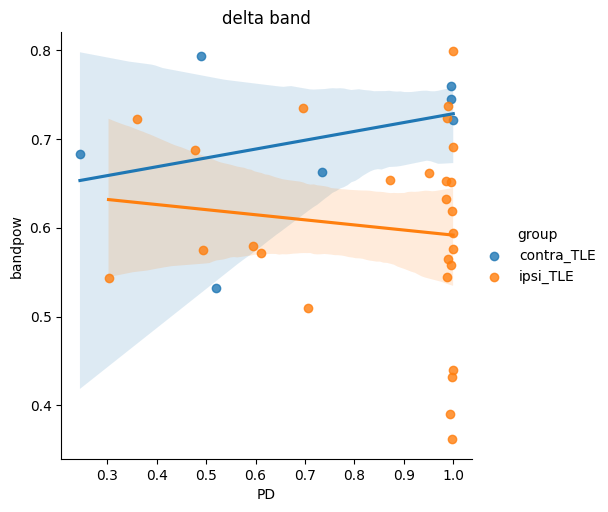

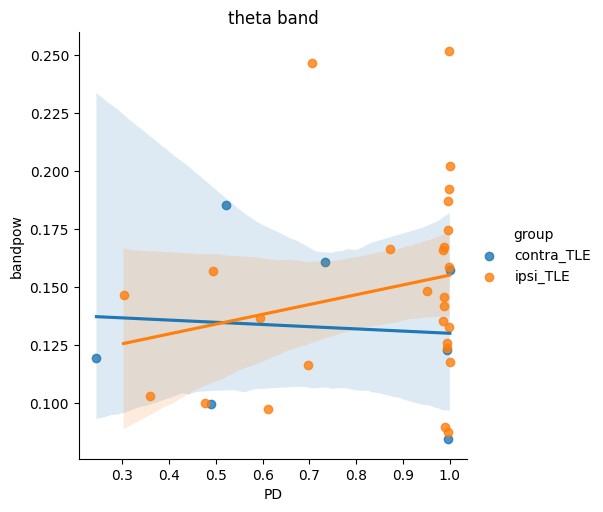

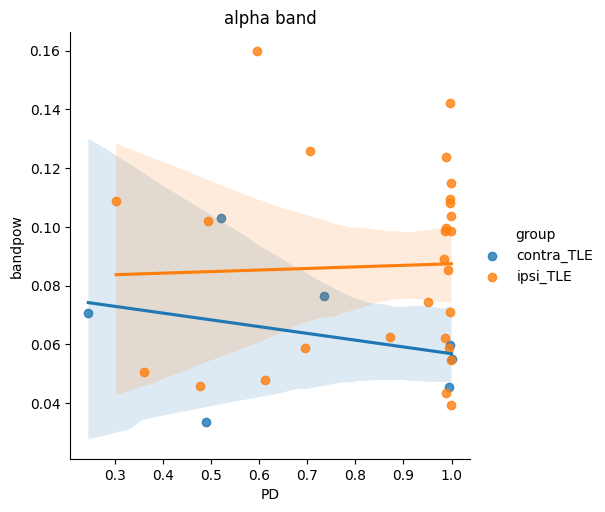

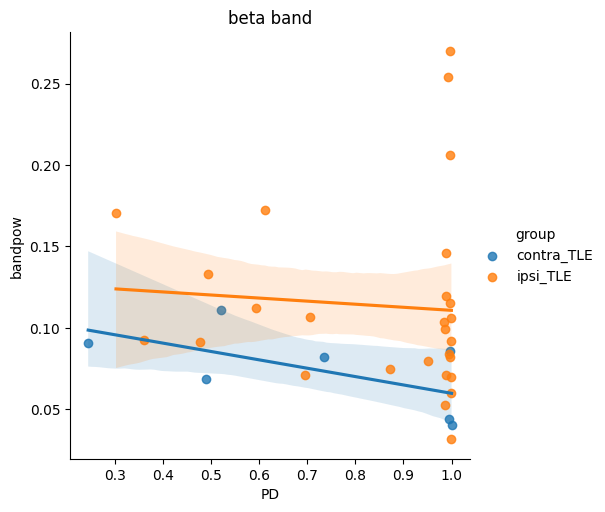

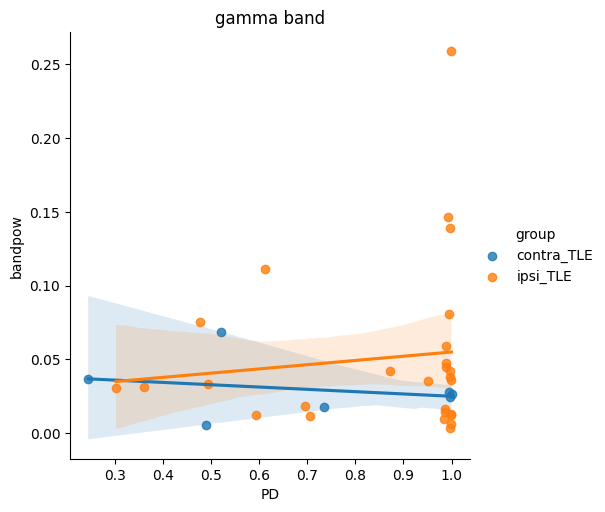

In [6]:
os.makedirs(f'./Results/{label_test}/bandpow_axis/', exist_ok = True)
for band in ds_bandpow['f_bands'].to_numpy():
    df_band = ds_bandpow.where(ds_bandpow.f_bands==band,drop=True).reset_index(['f_bands']).to_dataframe().reset_index(drop=True)
    sns.lmplot( x = "PD", 
                y = "bandpow", 
                hue = "group",
                data = df_band)
    ax = plt.gca()
    ax.set_title(f'{band} band')
    # plt.savefig(f'./Results/{label_test}/bandpow_axis/{band}_PD.png')

In [7]:
import analysis
print('Significant differences in slope')
p_c, permvals = analysis.permutation_test(ds_bandpow, 'group', 
                                          1000, analysis.get_slope_diff,
                                         dim='f_bands', y='PD')
analysis.eval_significance(p_c, list(ds_bandpow.f_bands.values))

Significant differences in slope
Median difference for true labels
Median diff delta: 1.473280281927445
Median diff theta: -1.8850274167374756
Median diff alpha: -4.326496304479711
Median diff beta: -6.905431554678862
Median diff gamma: -4.126069747781628
Significance without correction
p-val for delta: 0.155
p-val for theta: 0.509
p-val for alpha: 0.244
p-val for beta: 0.031
p-val for gamma: 0.173
Significance with correction (FDR)
corrected p-val for delta: 0.28833333333333333
corrected p-val for theta: 0.509
corrected p-val for alpha: 0.305
corrected p-val for beta: 0.155
corrected p-val for gamma: 0.28833333333333333


In [8]:
print('Significant differences in intercept')
p_c, permvals = analysis.permutation_test(ds_bandpow, 'group', 
                                          1000, analysis.get_intercept_diff,
                                         dim='f_bands', y='PD')
analysis.eval_significance(p_c, list(ds_bandpow.f_bands.values))

Significant differences in intercept
Median difference for true labels
Median diff delta: -1.144844301418319
Median diff theta: 0.13127045969099105
Median diff alpha: 0.14164135803318434
Median diff beta: 0.36529990175757077
Median diff gamma: -0.007249062537577067
Significance without correction
p-val for delta: 0.109
p-val for theta: 0.777
p-val for alpha: 0.691
p-val for beta: 0.224
p-val for gamma: 0.968
Significance with correction (FDR)
corrected p-val for delta: 0.5449999999999999
corrected p-val for theta: 0.968
corrected p-val for alpha: 0.968
corrected p-val for beta: 0.5599999999999999
corrected p-val for gamma: 0.968


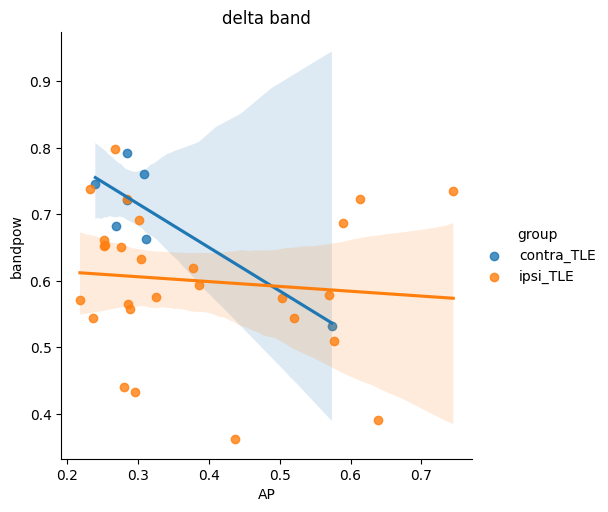

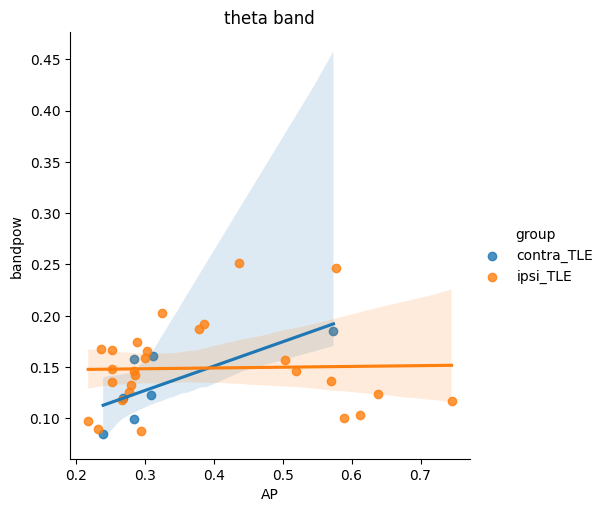

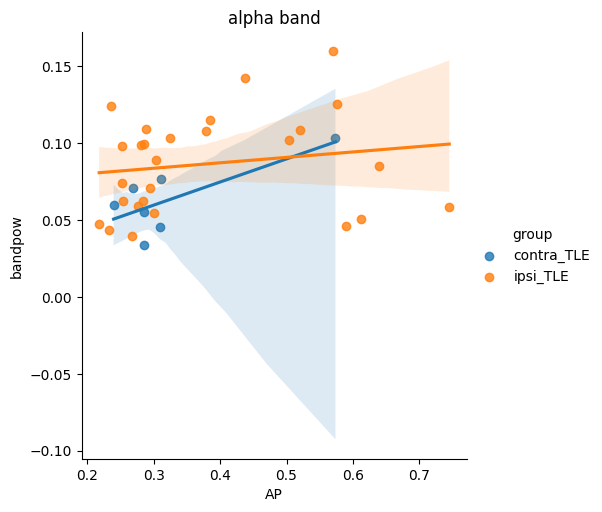

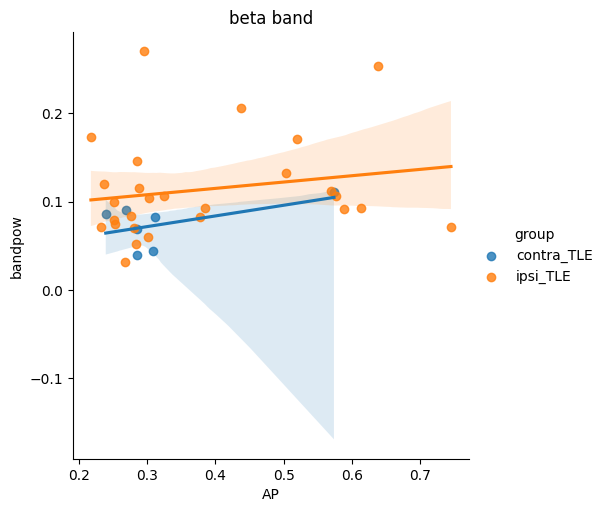

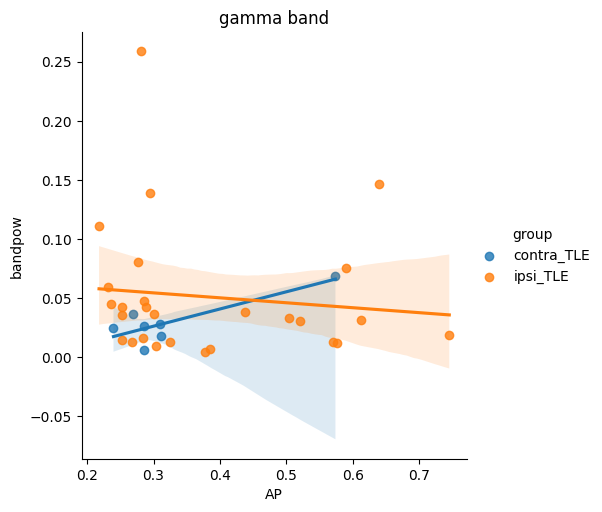

In [9]:
for band in ds_bandpow['f_bands'].to_numpy():
    df_band = ds_bandpow.where(ds_bandpow.f_bands==band,drop=True).reset_index(['f_bands']).to_dataframe().reset_index(drop=True)
    sns.lmplot( x = "AP", 
                y = "bandpow", 
                hue = "group",
                data = df_band)
    ax = plt.gca()
    ax.set_title(f'{band} band')
    # plt.savefig(f'./Results/{label_test}/bandpow_axis/{band}_AP.png')

In [10]:
import analysis
print('Significant differences in slope')
p_c, permvals = analysis.permutation_test(ds_bandpow, 'group', 
                                          1000, analysis.get_slope_diff,
                                         dim='f_bands', y='AP')
analysis.eval_significance(p_c, list(ds_bandpow.f_bands.values))

Significant differences in slope
Median difference for true labels
Median diff delta: -0.9731714724668292
Median diff theta: 2.1988320355860838
Median diff alpha: 2.887434717527508
Median diff beta: 1.8332001855979185
Median diff gamma: 5.039753975705261
Significance without correction
p-val for delta: 0.132
p-val for theta: 0.211
p-val for alpha: 0.139
p-val for beta: 0.175
p-val for gamma: 0.04
Significance with correction (FDR)
corrected p-val for delta: 0.211
corrected p-val for theta: 0.211
corrected p-val for alpha: 0.211
corrected p-val for beta: 0.211
corrected p-val for gamma: 0.19999999999999998


In [11]:
print('Significant differences in intercept')
p_c, permvals = analysis.permutation_test(ds_bandpow, 'group', 
                                          1000, analysis.get_intercept_diff,
                                         dim='f_bands', y='AP')
analysis.eval_significance(p_c, list(ds_bandpow.f_bands.values))

Significant differences in intercept
Median difference for true labels
Median diff delta: 0.6378940213420743
Median diff theta: -0.34767576699687613
Median diff alpha: -0.22191133170163263
Median diff beta: -0.17409283747972784
Median diff gamma: -0.21232269770461903
Significance without correction
p-val for delta: 0.133
p-val for theta: 0.208
p-val for alpha: 0.241
p-val for beta: 0.257
p-val for gamma: 0.045
Significance with correction (FDR)
corrected p-val for delta: 0.257
corrected p-val for theta: 0.257
corrected p-val for alpha: 0.257
corrected p-val for beta: 0.257
corrected p-val for gamma: 0.22499999999999998
